In [1]:
import ROOT as r
import math
import array
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages

from scipy.optimize import minimize
from scipy.signal import find_peaks

import numpy as np
from scipy.optimize import curve_fit

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


Welcome to JupyROOT 6.26/06


In [2]:
pas="1"
config="3"

W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
#dymin=-.984
#dymax=.9
#W2max=1.75
#dybgmin=-1.2
#dybgmax=1.2
#dxmin=-2
#dxmax=1
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -0.4
dxmax: 0.4
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Coin Min: 88 Coin Max: 100


In [3]:
import ROOT as r


def list_branches(rootfile_path, tree_name="Tout"):
    # Open the ROOT file
    root_file = r.TFile.Open(rootfile_path)
    
    # Check if the file was successfully opened
    if not root_file or root_file.IsZombie():
        print(f"Error: Could not open ROOT file '{rootfile_path}'.")
        return
    
    # Access the TTree
    tree = root_file.Get(tree_name)
    
    # Check if the tree exists
    if not tree:
        print(f"Error: Tree '{tree_name}' not found in file '{rootfile_path}'.")
        root_file.Close()
        return
    
    # Get the list of branches
    branch_list = tree.GetListOfBranches()
    
    # Print all branch names
    print(f"Branches in tree '{tree_name}':")
    for branch in branch_list:
        print(branch.GetName())
    
    # Close the ROOT file
    root_file.Close()

# Example usage
rootfile_path = "../outfiles/HCal_data_GEN3_sbs100p_nucleon_np_model1.root"
list_branches(rootfile_path)


Branches in tree 'Tout':
runnum
WCut
pCut
nCut
fiduCut
coinCut
ebeam
nu
Q2
W2
dpel
ephi
etheta
pcentral
vz
vx
vy
xtgt
ytgt
thtgt
phtgt
thetabend
xfp
yfp
thfp
phfp
trP
trPx
trPy
trPz
ePS
xPS
eSH
xSH
ySH
eHCAL
xHCAL
yHCAL
xHCAL_exp
yHCAL_exp
dx
dy
ngrinch_hits
xGRINCH
yGRINCH
coin_time
hcal_time
bbcal_time
BPMAx
BPMAy
Rasterx
Rastery
Raster2x
Raster2y
helicity
IHWP
pblkid
tdc
atime
nblk
mag
run
tar
cblkid
cblkatime
cblktime
cblke
nclus
cid
cx
cy
catime
hodoTimes
hodoIDs
hodoTOT
nbars
meanTOT
trigger
triggerID
NdataTriggerID
hodoClusMean


Error in <TList::Clear>: A list is accessing an object (0x42504360) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x42609430) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x42609860) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x426610d0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x42661440) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x426617b0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x42661ce0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x426620a0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x42662a00) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x42662d

In [4]:
#Access data from toshiba external drive, data is chunked into 2000000 event arrays
#directory: /media/research/TOSHIBA EXT/GEn/NumpyData/GEN3/HCal_data
#                                                            ^prefix of farm trimming script

#available array names: hodo{x}.npz hcal{x}.npz trigger{x}.npz

In [8]:
hodo=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/hodo1.npz")
trigger=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/trigger1.npz")
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/generic1.npz")
#hcal=np.load(f"media/research/TOSHIBA EXT/GEn/NumpyData/GEN{config}/HCal_data/hcal.npz")
print(hodo.files)
print(trigger.files)
print(generic.files)
#print(hcal.files)

['hodoTimes', 'hodoIDs', 'hodoTOT', 'nbars', 'hodoClusMean']
['trigger', 'triggerID', 'NdataTriggerID']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy']


In [8]:
# Access variables using their names
hodoTimes = hodo["hodoTimes"]
hodoIDs = hodo["hodoIDs"]
hodoClusMean=hodo["hodoClusMean"]
nbars = hodo["nbars"]
hodoTOT = hodo["hodoTOT"]
triggerT=trigger["trigger"]
triggerID=trigger["triggerID"]
NDatatrigger=trigger["NdataTriggerID"]
W2=generic["W2"]



In [9]:
def compute_tot_weighted_average(time, ids, nbar, TOT):
    tot_weighted_avg = []  # To store the results

    for i in range(len(nbar)):
        num_bars = nbar[i]  # Number of bars to consider for this event
        if num_bars > 0:
            # Select the first `num_bars` values for this event
            selected_tot = TOT[i, :num_bars]
            selected_time = time[i, :num_bars]

            # Compute the weighted average
            weights = selected_tot / np.sum(selected_tot)  # Normalize the weights
            weighted_avg = np.sum(weights * selected_time)
            tot_weighted_avg.append(weighted_avg)
        else:
            # If there are no bars, append NaN or 0 as needed
            tot_weighted_avg.append(hodoTimes[i][0])

    return np.array(tot_weighted_avg)

In [10]:
hodoMeanTime=compute_tot_weighted_average(hodoTimes,hodoIDs,nbars,hodoTOT)

# RF structure using the TH

In [11]:
#Cuts
mask=np.where(np.transpose(hodoIDs)[0].astype(int)==44)


In [12]:

hodoOffset=np.load("TDCOffsetHodo.npy")
hodoOffset[42]

1.0576820560814095

In [13]:
bbtrig=[]
rftrig=[]
hodoT=[]
passedcut=[]
for i in range(0,len(triggerT)):
        #cutBAR=int(hodoIDs[i][0])==42
        cutBAR=True
        cutTRIG=4 in triggerID[i][:NDatatrigger[i]] and 5 in triggerID[i][:NDatatrigger[i]] 
        cut=cutBAR and cutTRIG
        if cut:
            hodoT.append(hodoMeanTime[i])
            for j in range(0,NDatatrigger[i]):
                if triggerID[i][j]==4: 
                    rftrig.append(triggerT[i][j])
                    rf=True
                if triggerID[i][j]==5:
                    bbtrig.append(triggerT[i][j])
                    bb=True
            passedcut.append(i)

In [14]:
"""HodoMean=plt.hist(hodoMeanTime,bins=100,alpha=0.5,label='(tot1*time1+tot2*time2)/(tot1+tot2)')
HodoMean=plt.hist(hodoClusMean,bins=100,alpha=0.5,label='replay')

plt.title("TOT weighted avg of primary cluster bar 45")
plt.xlabel("ns")"""

'HodoMean=plt.hist(hodoMeanTime,bins=100,alpha=0.5,label=\'(tot1*time1+tot2*time2)/(tot1+tot2)\')\nHodoMean=plt.hist(hodoClusMean,bins=100,alpha=0.5,label=\'replay\')\n\nplt.title("TOT weighted avg of primary cluster bar 45")\nplt.xlabel("ns")'

446.1

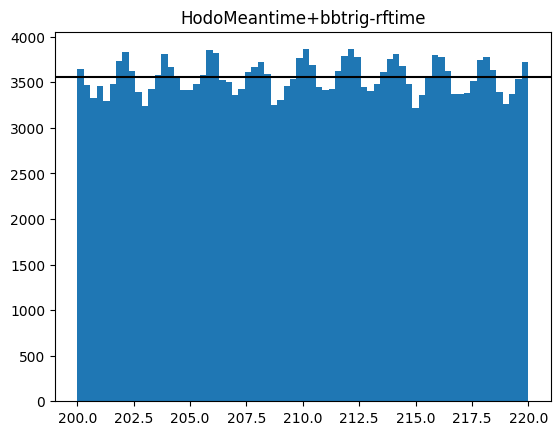

In [18]:



test=plt.hist(np.array(hodoT)+np.array(bbtrig)-np.array(rftrig),bins=100,range=(200,220))
plt.title("HodoMeantime+bbtrig-rftime")
hodoT = np.array(hodoT)
bbtrig = np.array(bbtrig)
rftrig = np.array(rftrig)
combined_data = hodoT + bbtrig - rftrig
counts, bin_edges = np.histogram(combined_data, bins=70, range=(200, 220))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], label='Data')


peaks, properties = find_peaks(counts, prominence=1)  # Adjust prominence threshold as needed
prominences = properties["prominences"]
    
    # Objective function: maximize peak prominence and minimize noise
total_prominence = np.mean(prominences)
noise_level = np.mean(counts)

plt.axhline(noise_level,color='black',label="Noise: mean of all bins")

total_prominence

In [19]:
bbtrig=[]
rftrig=[]
hodoT=[]
passedcut=[]
for i in range(0,len(triggerT)):
        #cutBAR=int(hodoIDs[i][0])==42
        bar=int(hodoIDs[i][0])
        cutBAR=True
        cutTRIG=4 in triggerID[i][:NDatatrigger[i]] and 5 in triggerID[i][:NDatatrigger[i]] 
        cut=cutBAR and cutTRIG
        if cut:
            hodoT.append(hodoMeanTime[i]+hodoOffset[bar])
            for j in range(0,NDatatrigger[i]):
                if triggerID[i][j]==4: 
                    rftrig.append(triggerT[i][j])
                    rf=True
                if triggerID[i][j]==5:
                    bbtrig.append(triggerT[i][j])
                    bb=True
            passedcut.append(i)

843.6

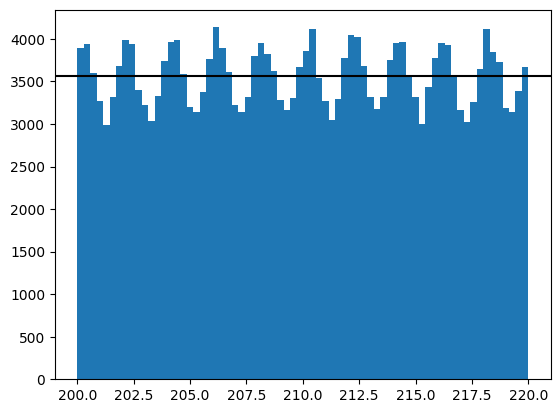

In [20]:
hodoT = np.array(hodoT)
bbtrig = np.array(bbtrig)
rftrig = np.array(rftrig)
combined_data = hodoT + bbtrig - rftrig
counts, bin_edges = np.histogram(combined_data, bins=70, range=(200, 220))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], label='Data')


peaks, properties = find_peaks(counts, prominence=1)  # Adjust prominence threshold as needed
prominences = properties["prominences"]
    
    # Objective function: maximize peak prominence and minimize noise
total_prominence = np.mean(prominences)
noise_level = np.mean(counts)

plt.axhline(noise_level,color='black',label="Noise: mean of all bins")

total_prominence

# Optimization Algorithm

In [21]:
#First organize the arrays so everything has same size and is ready for optimization

In [22]:
bbtrig=[]
rftrig=[]
hodoT=[]
passedcut=[]
barIDS=[]
#for i in range(0,len(triggerT)):
for i in range(0,100000):
    #cutBAR=int(hodoIDs[i][0])==42
    bar=int(hodoIDs[i][0])
    cutBAR=True
    cutTRIG=4 in triggerID[i][:NDatatrigger[i]] and 5 in triggerID[i][:NDatatrigger[i]] 
    cut=cutBAR and cutTRIG
    if cut:
        hodoT.append(hodoMeanTime[i])
        barIDS.append(bar)
        for j in range(0,NDatatrigger[i]):
            if triggerID[i][j]==4: 
                rftrig.append(triggerT[i][j])
                rf=True
            if triggerID[i][j]==5:
                bbtrig.append(triggerT[i][j])
                bb=True
        passedcut.append(i)

In [23]:
def objective_function(offsets, hodoT, bbtrig, rftrig,bars):
    adjusted_times = []
    
    for i in range(0,len(hodoT)):
        adjusted_times.append(hodoT[i]+bbtrig[i]-rftrig[i]+offsets[bars[i]])
    
    counts, bin_edges = np.histogram(adjusted_times, bins=50, range=(200, 220))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    peaks, properties = find_peaks(counts, prominence=1)  # Adjust prominence threshold as needed
    prominences = properties["prominences"]
    
    total_prominence = np.sum(prominences)
    noise_level = np.mean(counts)  # Simple measure of background noise
    lambda_weight = 0.5  # Weighting factor, adjust as needed
    
    return -total_prominence + lambda_weight * noise_level

In [24]:
objective_function(hodoOffset,hodoT,bbtrig,rftrig,barIDS)

-551.12

In [52]:
def optimize_offsets_individually(objective_function, offsets, hodoT, bbtrig, rftrig, bars, step_size=.5, max_iterations=100):
    best_offsets = np.copy(offsets)
    for j in range(max_iterations):
        print(f"Iterations: {j}")
        improved = False
        for i in range(len(offsets)):
            # Store the current best score for comparison
            best_score = objective_function(best_offsets, hodoT, bbtrig, rftrig, bars)
            original_offset = best_offsets[i]
            best_local_offset = original_offset

            # Try different adjustments within the range [-2, 2]
            for delta in np.arange(-1, 1 + step_size, step_size):
                # Adjust only the current offset
                best_offsets[i] = original_offset + delta
                
                # Evaluate the objective function
                score = objective_function(best_offsets, hodoT, bbtrig, rftrig, bars)
                # Update if we find a better score
                if score < best_score:
                    best_score = score
                    print(best_score)
                    best_local_offset = best_offsets[i]
                    improved = True

            # Set the offset to the best found in this iteration
            best_offsets[i] = best_local_offset
        print(best_offsets)
        # If no improvement across all offsets, stop early
        if not improved:
            break

    return best_offsets

In [53]:
newOffsets=optimize_offsets_individually(objective_function,hodoOffset,hodoT,bbtrig,rftrig,barIDS)

Iterations: 0
304.0500000000002
302.07000000000016
277.07000000000016
269.02
262.0500000000002
260.03999999999996
221.25
201.13999999999987
131.23999999999978
131.23000000000002
-35.80000000000018
-44.80000000000018
-84.82000000000016
-121.86000000000013
-266.98
-412.1199999999999
-450.17999999999984
-539.0799999999999
-767.0900000000001
-858.1199999999999
-1400.9899999999998
-1443.0500000000002
-1886.0700000000002
-1941.08
-1968.1999999999998
-2186.37
-2233.5
-2825.79
-3644.97
-3671.52
-4773.52
-4791.49
-5867.2
-6006.09
-6540.99
-6840.25
-7516.1
-7693.030000000001
-7878.75
-8189.21
-8650.9
-9598.93
-9647.83
-10187.630000000001
-10637.51
-11277.5
-11341.98
-11448.95
-12058.94
-12709.17
-12715.14
-12964.07
-14574.53
-15120.51
-15452.64
-16431.46
-17287.55
-17293.39
-17768.48
-17807.67
-18226.53
-19329.82
-19364.61
-20408.86
-20415.82
-21153.44
-22134.4
-23246.35
-24513.85
-25987.7
-26008.06
-26468.91
-26812.79
-27274.03
-27395.98
-27405.07
-27482.12
-27583.06
-27611.0
-27622.02
-27639.9

KeyboardInterrupt: 

In [ ]:
#result = minimize(objective_function, hodoOffset, args=(hodoT, bbtrig, rftrig,barIDS), method='Nelder-Mead')

In [54]:
newOffsets = [-0.23451742, 1.19847798, 1.33888895, -2.11197089, 1.92312337, -0.42380316,
 0.53680124, -2.29562224, -0.97795521, -0.6397011, 0.69513374, 0.56397918,
 -1.9160034, -0.15051071, -1.10540197, -1.2442704, -0.5686851, -0.74024629,
 -0.89333093, -1.21491966, -0.74153578, -1.5229279, -2.27975243, -0.22163366,
 -0.23393748, -1.42278159, -2.47650211, -1.13106055, -1.1516516, -1.1539263,
 -2.70354442, -1.15498059, -0.12639753, -0.74563607, 0.98962874, 1.08688091,
 1.28548984, 1.29500506, 1.20749009, 1.18341729, 0.79419291, 0.86822948,
 1.05768206, 1.29373744, 1.06776752, 1.0, -0.29237064, -0.78807789,
 -0.47836709, -0.23994616, 1.87223776, 1.34222524, 1.19101147, 1.45285309,
 -0.13314883, 1.56224682, -0.42242138, 1.84853408, 1.39725373, 1.67898546,
 1.12612084, 1.1963534, 1.43175981, 1.39765873, 3.44781839, 1.45033485,
 -0.13139367, -0.30595536, 0.15667456, -1.95948636, -2.75641325, -3.34173736,
 -4.02871037, -3.54634517, -3.49614346, -3.52600112, -2.37525326, -5.29470076,
 -3.28945425, -5.23730837, -3.03295491, -4.86459255, -5.05830659, -4.68142971,
 2.29270852, 0.0, 0.0, -0.5, 0.0]


In [55]:
bbtrig=[]
rftrig=[]
hodoT=[]
passedcut=[]
barIDS=[]
for i in range(0,len(triggerT)):
    #cutBAR=int(hodoIDs[i][0])==42
    bar=int(hodoIDs[i][0])
    cutBAR=True
    cutTRIG=4 in triggerID[i][:NDatatrigger[i]] and 5 in triggerID[i][:NDatatrigger[i]] 
    cut=cutBAR and cutTRIG
    if cut:
        hodoT.append(hodoMeanTime[i]+newOffsets[bar])
        barIDS.append(bar)
        for j in range(0,NDatatrigger[i]):
            if triggerID[i][j]==4: 
                rftrig.append(triggerT[i][j])
                rf=True
            if triggerID[i][j]==5:
                bbtrig.append(triggerT[i][j])
                bb=True
        passedcut.append(i)

205.2941176470588

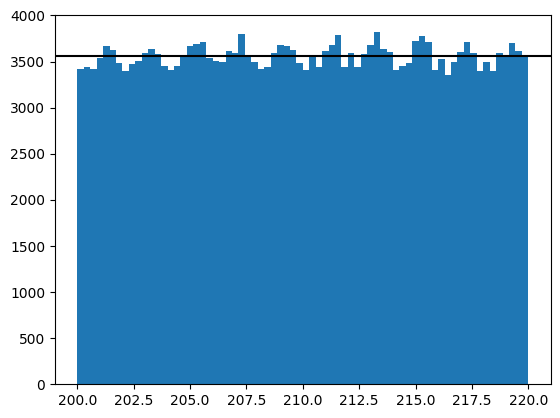

In [56]:
hodoT = np.array(hodoT)
bbtrig = np.array(bbtrig)
rftrig = np.array(rftrig)
combined_data = hodoT + bbtrig - rftrig
counts, bin_edges = np.histogram(combined_data, bins=70, range=(200, 220))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], label='Data')


peaks, properties = find_peaks(counts, prominence=1)  # Adjust prominence threshold as needed
prominences = properties["prominences"]
    
    # Objective function: maximize peak prominence and minimize noise
total_prominence = np.mean(prominences)
noise_level = np.mean(counts)

plt.axhline(noise_level,color='black',label="Noise: mean of all bins")

total_prominence

# RF Structure using HCal

In [ ]:

hcal_rftime=[]
hcal_time=[]
passedcut=[]
hcal_blockIDS=[]
for i in range(0,len(hcalBlockIDS)):
    #for i in range(0,100000):
    #cutBAR=int(hodoIDs[i][0])==42
    block=int(hcalBlockIDS[i][0])
    cutBAR=True
    cutTRIG=4 in triggerID[i][:NDatatrigger[i]] and 5 in triggerID[i][:NDatatrigger[i]] 
    cut=cutBAR and cutTRIG
    if cut:
        hcal_time.append(hcalADCTime[i])
        hcal_blockIDS.append(bar)
        for j in range(0,NDatatrigger[i]):
            if triggerID[i][j]==4: 
                rftrig.append(triggerT[i][j])
                rf=True
            if triggerID[i][j]==5:
                bbtrig.append(triggerT[i][j])
                bb=True
        passedcut.append(i)